In [3]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [122]:
path= '/content/drive/My Drive/PROJECT/news_data'

df_1 = pd.read_table(path+"/news_data.csv",index_col=False,sep=",")
df_2 = pd.read_table(path+"/news_data2.csv",index_col=False,sep=",")

In [123]:
len(df)

8827

In [116]:
df_1.describe()

,news,code
count,5124,5124
unique,3996,3
top,기사 섹션 분류 안내\n\n기사의 섹션 정보는 해당 언론사의 분류를 따르고 있습니다...,사회
freq,359,2000


In [117]:
df_2.describe()

,news,code
count,3703,3703
unique,2141,4
top,기사 섹션 분류 안내\n\n기사의 섹션 정보는 해당 언론사의 분류를 따르고 있습니다...,사회
freq,502,1000


In [172]:
df=pd.concat([df_1,df_2],axis=0,ignore_index=True)

# Preprocessing

### **불용어 제거**

In [174]:
# 정규 표현식을 이용해서 한글 외의 문자는 전부 제거합니다.
df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df['news']

0       파주시청 사진제공파주시 파주시청 사진제공파주시파주파이낸셜뉴스 강근주 기자 파주시는 ...
1       동영상 뉴스이천 물류창고 화재 발화지점으로 지목된 지하 층에서 산소절단기의 산소 공...
2       황범순 의정부시 부시장 을지대학교 의정부캠퍼스 및 부속병원 공사현장 안전점검 사진제...
3       귀갓길 여성을 쫓아가 성범죄를 시도한 대 남성이 구속됐습니다서울 강남경찰서는 강간상...
4       서울연합뉴스 대한약사회가 일부터 코로나바이러스 감염증 대응 체계를 사회적 거리두기에...
                              ...                        
8822    레고켐바이오사이언스대표 김용주사진가 글로벌 기술수출에 또다시 성공했다 년 중국 포순...
8823    제대 국회의원선거 기간 중단됐던 네이버 실시간 급상승 검색어 서비스가 일 오후 시부...
8824    아마존 연합뉴스 자료사진 아마존 연합뉴스 자료사진직원들 코로나 확산 방지 조치 충분...
8825    제대 국회의원선거가 임박한 가운데 투표 및 개표 방송을 준비하는 기업들의 움직임이 ...
8826    롤 점검이 일 진행될 예정이다온라인게임 리그오브레전드이하 롤은 일 오전 시부터 오전...
Name: news, Length: 8827, dtype: object

In [175]:
print(df.isnull().sum())

news    0
code    0
dtype: int64


In [176]:
# 중복된 샘플들을 제거합니다.
df.drop_duplicates(subset=['news'], inplace=True)

print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  6127


In [177]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


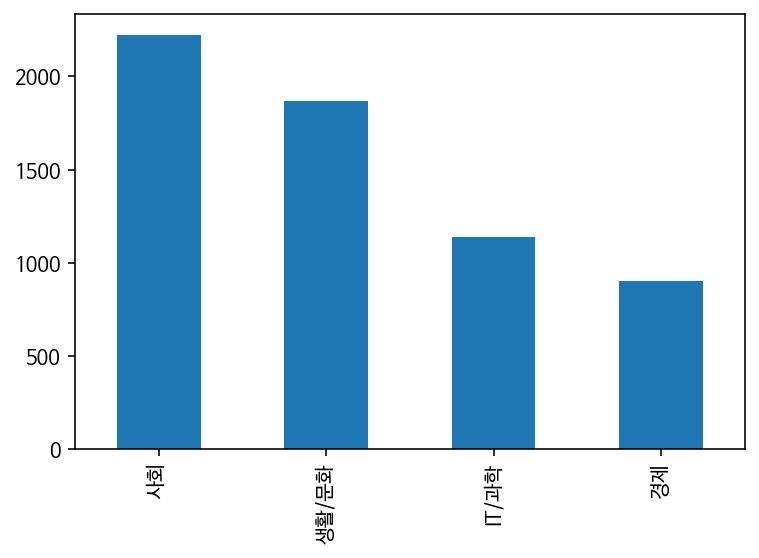

In [178]:
df['code'].value_counts().plot(kind = 'bar')

### **토큰화**

In [297]:
#설치하고 런타임 다시 시작 
!apt-get update
!apt-get install g++ openjdk-8-jdk 
!pip3 install konlpy JPype1-py3
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:4 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:11 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-

In [301]:
from konlpy.tag import Mecab
tokenizer = Mecab()

In [260]:
stopwords = ['에','는','은','을','했','에게','있','이','의','하','한','다','과','때문','할','수','무단','따른','및','금지','전재','경향신문','기자','는데','가','등','들','파이낸셜','저작','등','뉴스','노컷뉴스','매일신문','그','나오','가지','씨','시키','만들','지금','생각하','그러','속','하나','집','살','모르','적','월','데','자신','안','어떤','내','경우','명','생각','시간','그녀','다시','이런','앞','보이','번','나','다른','어떻','여자','개','전','들','사실','이렇','점','싶','말','정도','좀','원','잘','통하','소리','놓','권','자','재','될','고','되','며','주','인','시','일','파','만','총','게','태','스','크','를','어','당','각','지난','관련','지만','사람','입니다','습니다','밝혔','지만','면서','지난','우리','이상','이용','경우','뉴시스','까지','다는','다면']

In [261]:
# 토큰화 및 토큰화 과정에서 불용어를 제거하는 함수입니다.
def preprocessing(data):
  text_data = []

  for sentence in data:
    temp_data = []
    #- 토큰화
    temp_data = tokenizer.morphs(sentence) 
    #- 불용어 제거
    temp_data = [word for word in temp_data if not word in stopwords] 
    text_data.append(temp_data)

  text_data = list(map(' '.join, text_data))

  return text_data

In [262]:
text_data = preprocessing(df['news'])

# Data Split

In [141]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [263]:
#- 훈련 데이터와 테스트 데이터를 분리합니다.
X_train, X_test, y_train, y_test = train_test_split(text_data, df['code'], random_state = 0)

In [264]:
print('훈련용 뉴스 기사의 개수 :', len(X_train))
print('테스트용 뉴스 기사의 개수 : ', len(X_test))
print('훈련용 레이블의 개수 : ', len(y_train))
print('테스트용 레이블의 개수 : ', len(y_test))

훈련용 뉴스 기사의 개수 : 4595
테스트용 뉴스 기사의 개수 :  1532
훈련용 레이블의 개수 :  4595
테스트용 레이블의 개수 :  1532


### **TOP100 wordvec plot**

In [265]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features = 100, max_df=0.95, min_df=0)

#generate tf-idf term-document matrix
A_tfidf_sp = tfidf.fit_transform(X_test) 

In [266]:
tfidf_dict = tfidf.get_feature_names()
print(tfidf_dict)

['가능', '가장', '개발', '거리', '게임', '결과', '경제', '계획', '관계자', '광주', '교육', '국내', '국립', '국민', '국회', '기술', '기업', '기준', '다고', '다며', '다양', '대구', '대비', '대상', '대표', '대한', '더불', '도록', '된다', '따라', '따르', '라고', '라는', '마스크', '문화', '미국', '민주당', '바이러스', '발생', '발표', '방역', '배포', '보다', '부터', '분기', '사업', '사용', '사진', '사회', '산업', '상황', '생활', '서비스', '서울', '선거', '세계', '센터', '시설', '시작', '시장', '아니', '에서', '연구', '연합뉴스', '영상', '예정', '오후', '온라인', '올해', '운영', '위한', '위해', '으로', '이날', '이번', '이후', '전국', '정보', '정부', '제공', '지난해', '지역', '지원', '진행', '총선', '최근', '코로나', '통합', '통해', '판매', '한국', '한다', '한다고', '함께', '해야', '현재', '확산', '확인', '활용', '후보']


In [267]:
data_array = A_tfidf_sp.toarray()
data = pd.DataFrame(data_array, columns=tfidf_dict)
data.shape

(1532, 100)

In [268]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, n_iter=10000, verbose=1)

In [269]:
data_array.shape

(1532, 100)

In [270]:
data_array.T.shape

(100, 1532)

In [271]:
Z = tsne.fit_transform(data_array.T)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 1.263878
[t-SNE] KL divergence after 250 iterations with early exaggeration: 97.018570
[t-SNE] KL divergence after 2300 iterations: 0.559019


In [272]:
print(Z[0:5])
print('Top words: ',len(Z))

[[-0.37917328 -4.6112494 ]
 [-0.11034995 -3.114073  ]
 [-0.53692997 -6.502993  ]
 [-4.009951   -3.1981697 ]
 [ 2.4926848  -6.0293455 ]]
Top words:  100


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


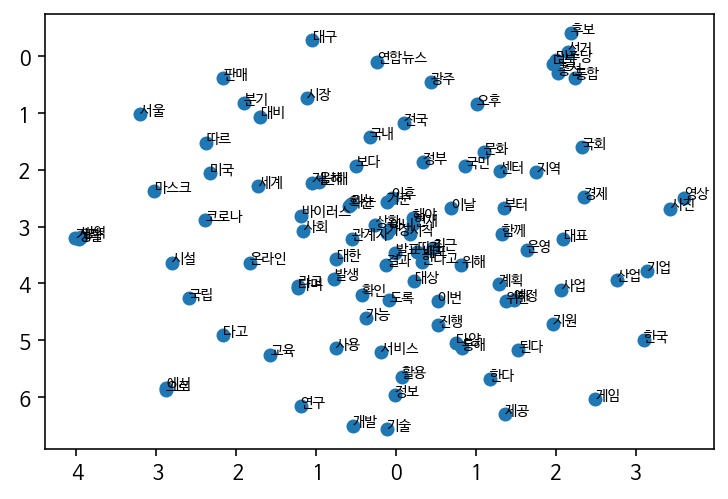

In [273]:
fontprop = fm.FontProperties(size=7)
plt.scatter(Z[:,0], Z[:,1])
for i in range(len(tfidf_dict)):
    plt.annotate(s=tfidf_dict[i].encode("utf8").decode("utf8"), xy=(Z[i,0], Z[i,1]),fontProperties =fontprop)

plt.draw()

# Classification

In [274]:
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [275]:
def tfidf_vectorizer(data):
  data_counts = count_vect.transform(data)
  data_tfidf = tfidf_transformer.transform(data_counts)
  return data_tfidf

In [276]:
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))
#F1-Score는 정밀도와 재현율을 동등하게 계산한 경우이며
#정밀도에 더 가중치를 주고 싶은경우 β를 1 이상으로 입력
#재현율에 더 가중치를 주고 싶은경우 β를 0~1로 입력
#macro 단순평균
#weighted 각 클래스에 속하는 표본의 갯수로 가중평균
#accuracy 정확도. 전체 학습데이터의 개수에서 각 클래스에서 자신의 클래스를 정확하게 맞춘 개수의 비율

              precision    recall  f1-score   support

       IT/과학       0.86      0.72      0.78       288
          경제       0.91      0.42      0.57       236
          사회       0.73      0.92      0.81       553
       생활/문화       0.75      0.80      0.77       455

    accuracy                           0.77      1532
   macro avg       0.81      0.71      0.73      1532
weighted avg       0.79      0.77      0.76      1532



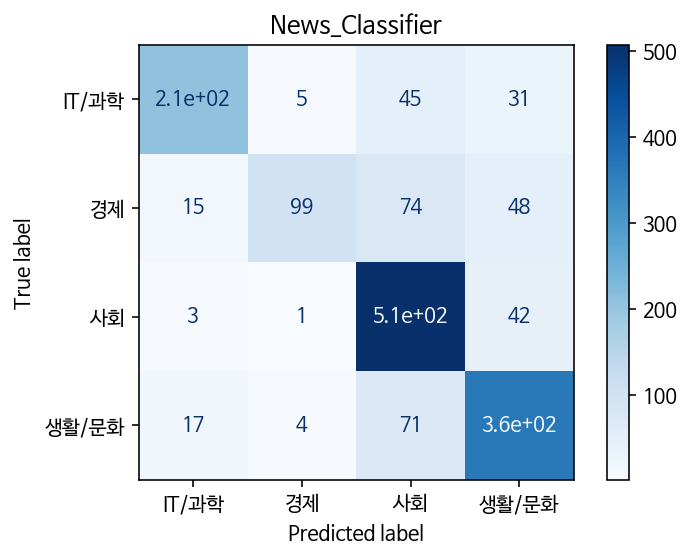

In [277]:
from sklearn.metrics import plot_confusion_matrix

disp = plot_confusion_matrix(clf, tfidf_vectorizer(X_test), y_test,
                             cmap=plt.cm.Blues)
disp.ax_.set_title("News_Classifier")
plt.show()

## ***svm***

In [278]:
from sklearn.linear_model import SGDClassifier
text_clf = Pipeline([('clf', SGDClassifier(loss='hinge', penalty='l2',
                       alpha=1e-3, random_state=42,
                       max_iter=5, tol=None))
])

In [279]:
text_clf.fit(X_train_tfidf, y_train)

Pipeline(memory=None,
         steps=[('clf',
                 SGDClassifier(alpha=0.001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                               max_iter=5, n_iter_no_change=5, n_jobs=None,
                               penalty='l2', power_t=0.5, random_state=42,
                               shuffle=True, tol=None, validation_fraction=0.1,
                               verbose=0, warm_start=False))],
         verbose=False)

In [280]:
y_pred = text_clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       IT/과학       0.80      0.82      0.81       288
          경제       0.86      0.68      0.76       236
          사회       0.86      0.89      0.87       553
       생활/문화       0.79      0.83      0.81       455

    accuracy                           0.83      1532
   macro avg       0.83      0.80      0.81      1532
weighted avg       0.83      0.83      0.82      1532



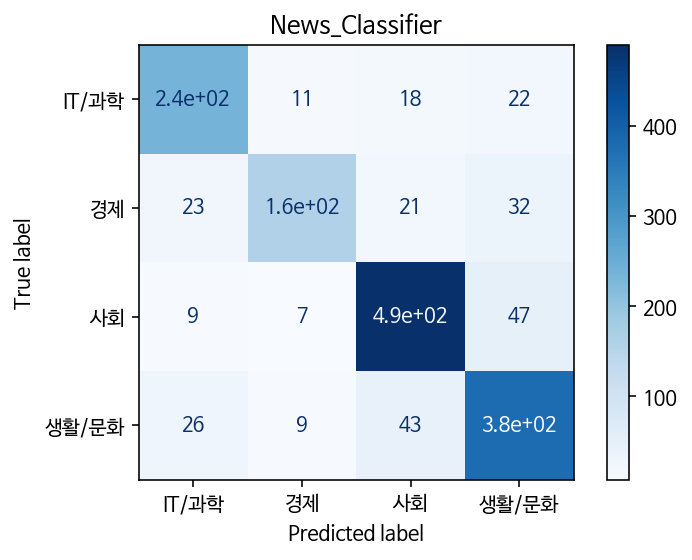

In [281]:
from sklearn.metrics import plot_confusion_matrix

disp = plot_confusion_matrix(text_clf, tfidf_vectorizer(X_test), y_test,
                             cmap=plt.cm.Blues)
disp.ax_.set_title("News_Classifier")
plt.show()